#### This notebook uses code from notebooks/automatic_mask_generator_example
#### To load in images, run the default SAM model to create masks
#### and use those masks to change the background of the image

## Environment Set-up - Colab

If running locally using jupyter, first install `segment_anything` in your environment using the [installation instructions](https://github.com/facebookresearch/segment-anything#installation) in the repository. If running from Google Colab, set `using_colab=True` below and run the cell. In Colab, be sure to select 'GPU' under 'Edit'->'Notebook Settings'->'Hardware accelerator'.

In [1]:
using_colab = False

In [2]:
if using_colab:
    import torch
    import torchvision
    print("PyTorch version:", torch.__version__)
    print("Torchvision version:", torchvision.__version__)
    print("CUDA is available:", torch.cuda.is_available())
    import sys
    # !{sys.executable} -m pip install opencv-python matplotlib
    # !{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
    
    # !mkdir images
    # !wget -P images https://raw.githubusercontent.com/facebookresearch/segment-anything/main/notebooks/images/dog.jpg
        
    # !wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

## Set-up - Local

In [3]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2
import time
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE" # this is so that inline plotting doesn't crash the kernel

In [4]:
os.getcwd()

'C:\\Users\\wadiav\\Documents\\PYTHON\\FaceFamiliarity\\BackgroundRemoval_SegAny'

In [5]:
def show_anns(anns):
    if len(anns) == 0:
        return
    sorted_anns = sorted(anns, key=(lambda x: x['area']), reverse=True)
    ax = plt.gca()
    ax.set_autoscale_on(False)

    img = np.ones((sorted_anns[0]['segmentation'].shape[0], sorted_anns[0]['segmentation'].shape[1], 4))
    img[:,:,3] = 0
    for ann in sorted_anns:
        m = ann['segmentation']
        color_mask = np.concatenate([np.random.random(3), [0.35]])
        img[m] = color_mask
    ax.imshow(img)

## Automatic mask generation

To run automatic mask generation, provide a SAM model to the `SamAutomaticMaskGenerator` class. Set the path below to the SAM checkpoint. Running on CUDA and with the default model is recommended.

In [6]:
t1 = time.time()
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cpu" # GPU doesn't have enough compute and keep running out of memory

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

# specific params for faces
mask_generator = SamAutomaticMaskGenerator(
    sam, 
    points_per_batch=1024, 
    points_per_side=2,
    min_mask_region_area=10000
)
# mask_generator = SamAutomaticMaskGenerator(sam)
t2 = time.time()

print(t2-t1)

4.207858562469482


In [7]:
mask_generator.point_grids

[array([[0.25, 0.25],
        [0.75, 0.25],
        [0.25, 0.75],
        [0.75, 0.75]])]

In [8]:
imPath = os.path.join(os.getcwd(), 'P92CS\FamFaces_Pt_P92CS_Aligned')
imPath

'C:\\Users\\wadiav\\Documents\\PYTHON\\FaceFamiliarity\\BackgroundRemoval_SegAny\\P92CS\\FamFaces_Pt_P92CS_Aligned'

Load in all images and run `generate` on them in turn

#### NOTE: This takes a long time - do this night before

In [35]:
# imPath = os.path.join(os.getcwd(), 'CelebFaces_Pt_Varun_Aligned_100')
# imageOutPath = os.path.join(os.getcwd(), 'CelebFaces_Pt_Varun_Processed_100')

# imPath = os.path.join(os.getcwd(), 'FewIms_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'FewIms_Processed')

# imPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P87CS_2_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P87CS_2_Processed')

# imPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P86CS_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P86CS_Processed')

# imPath = os.path.join(os.getcwd(), 'P92CS\FamFaces_Pt_P92CS_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'P92CS\FamFaces_Pt_P92CS_Processed')

imPath = os.path.join(os.getcwd(), 'P98CS\Im_Aligned')
# imPath = os.path.join(os.getcwd(), 'P98CS\ExtraFaces_Aligned')
imageOutPath = os.path.join(os.getcwd(), 'P98CS\ExtraFaces_Processed')

# CHANGE THE OUTNAME OF MASKS AT THE BOTTOM OF LOOP TO MATCH FOLDER NAMES
if os.path.exists(imageOutPath) is False:
    os.mkdir(imageOutPath)
    
t1 = time.time()
im_mask = list() 
ctr = 0 # lol python

for files in os.listdir(imPath):
    
    # read in file
    im_path_in = os.path.join(imPath, files)
    image = cv2.imread(im_path_in)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # rename file
    name = files.split('.')
    prefix = name[0]
    im_name_out = prefix.zfill(4) + '.' + name[1]
    im_path_out = os.path.join(imageOutPath, im_name_out) 
    # print(im_path_out)
    
    # create masks and save
    masks = mask_generator.generate(image) # create all masks
    segsum = []
    for i in range(len(masks)):
        segsum.append(sum(sum(masks[i]['segmentation'])))
    
    chosenMask = max(enumerate(segsum),key=lambda x: x[1])[0]
    newseg = masks[chosenMask]['segmentation'] # choose the last one
    im_mask.append(newseg.astype(np.uint8)) # change variable time 
    ctr = ctr + 1
    print("Finished for image " + str(ctr))


# outName = 'Mamelak_FamMask_P98CS_' + str(len(os.listdir(imPath))) + '.npy'  
outName = 'TJMiller_FamMask_P98CS_' + str(len(os.listdir(imPath))) + '.npy'  
# outName = 'FamMasks_P98CS_' + str(len(os.listdir(imPath))) + '.npy'  
# outName = 'FamMasks_P92CS_' + str(len(os.listdir(imPath))) + '.npy'  
# outName = 'FewMasks_P86CS_' + str(len(os.listdir(imPath))) + '.npy'  
np.save(outName,  im_mask)
t2 = time.time()
print(t2 - t1)

Finished for image 1
16.53771471977234


In [10]:
len(im_mask)

1

In [11]:
outName

'Mamelak_FamMask_P98CS_1.npy'

### Using the masks to create background subtracted pictures

In [36]:
# imPath = os.path.join(os.getcwd(), 'CelebFaces_Pt_Varun_Aligned_100')
# imageOutPath = os.path.join(os.getcwd(), 'CelebFaces_Pt_Varun_Processed_100')

# imPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P87CS_2_Aligned')
# imPath = os.path.join(os.getcwd(), 'FewIms_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P87CS_2_Processed')

# imPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P86CS_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'FamFaces_Pt_P86CS_Processed')

# imPath = os.path.join(os.getcwd(), 'P92CS\FamFaces_Pt_P92CS_Aligned')
# imageOutPath = os.path.join(os.getcwd(), 'P92CS\FamFaces_Pt_P92CS_Processed')

# imPath = os.path.join(os.getcwd(), 'P98CS\ExtraFaces_Aligned')
imPath = os.path.join(os.getcwd(), 'P98CS\Im_Aligned')
imageOutPath = os.path.join(os.getcwd(), 'P98CS\ExtraFaces_Processed')

if os.path.exists(imageOutPath) is False:
    os.mkdir(imageOutPath)

# outName = 'FamMasks_' + str(len(os.listdir(imPath))) + '.npy'
# outName = 'FamMasks_P87CS_2_' + str(len(os.listdir(imPath))) + '.npy'  

im_mask = np.load(outName)
colors = [192, 192, 192]
ctr = 0

for files in os.listdir(imPath):
    # read in the image
    im_path_in = os.path.join(imPath, files)
    image = cv2.imread(im_path_in)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # name output file
    name = files.split('.')
    prefix = name[0]
    im_name_out = prefix.zfill(4) + '.' + name[1]
    im_path_out = os.path.join(imageOutPath, im_name_out) 
    
    # read in the mask
    mask_tile = im_mask[ctr].astype(np.uint8)
    mask_tile = cv2.cvtColor(mask_tile,cv2.COLOR_GRAY2RGB)
    mask_tile = mask_tile*255 # this is a stupid hack but sort of works

    out = cv2.subtract(mask_tile, image)
    out[np.where((out == [0, 0, 0]).all(axis = 2))] = [colors]
    out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
    result = np.where(mask_tile, image, out)
    
    # print the result
    result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB) # else they print in BGR
    cv2.imwrite(im_path_out, result)
    print("Finished for image " + str(ctr))
    ctr = ctr + 1


Finished for image 0


In [ ]:
for files in os.listdir(imPath):
    name = files.split('.')
    prefix = name[0]
    if prefix in ['3505', '3029', '3033']:
        print(files)

In [ ]:
type(prefix)

In [ ]:
imageOutPath

## Example image

In [73]:
# imPath = os.path.join(os.getcwd(), 'P92CS\Im_Aligned')
imPath = os.path.join(os.getcwd(), 'P98CS\ExtraFaces_Aligned')

# im_path_in = os.path.join(imPath, '3407.jpg')
im_path_in = os.path.join(imPath, 'MileyC.jpg')
image = cv2.imread(im_path_in)
# image = cv2.imread('FamFaces_Pt_P87CS_2_Aligned/3009.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

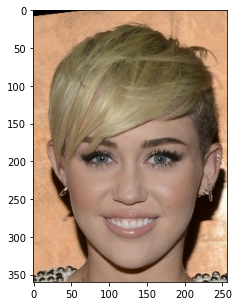

In [74]:
plt.figure(figsize=(5,5))
plt.imshow(image)

In [75]:
# specific params for faces
mask_generator = SamAutomaticMaskGenerator(
    sam, 
    points_per_batch=1024, 
    points_per_side=4,
    min_mask_region_area=10000
)
masks = mask_generator.generate(image) # create all masks
len(masks)

4

In [76]:
newseg = list()
for i in range(len(masks)):
    # if np.array_equal(masks[i]['segmentation'], masks[i+1]['segmentation']) is False:
        newseg.append(masks[i]['segmentation'].astype(np.uint8))

In [77]:
segsum = []
for i in range(len(masks)):
    segsum.append(sum(sum(masks[i]['segmentation'])))
    
chosenMask = max(enumerate(segsum),key=lambda x: x[1])[0]
chosenMask

0

In [78]:
# newseg = masks[4]['segmentation'] +masks[0]['segmentation'] # choose the last one
# newseg = masks[3]['segmentation'] # choose the last one
newseg = masks[chosenMask]['segmentation']

In [ ]:
max(t1)

In [ ]:
type(im_mask[0])

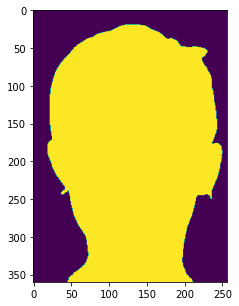

In [79]:
# in doggie case masks[0]['segmentation'] is what we want
# For faces maybe use newseg[-1]? 
# immask = newseg[0].astype(np.uint8) + newseg[1].astype(np.uint8)
immask = newseg.astype(np.uint8)
plt.figure(figsize=(5,5))
plt.imshow(immask)

In [80]:
colors = [192, 192, 192]
ori_img = image
# mask_tile = np.tile(im_mask[:, :, np.newaxis], [1, 1, 3])
mask_tile = cv2.cvtColor(immask,cv2.COLOR_GRAY2RGB)
mask_tile = mask_tile*255 # this is a stupid hack but sort of works

obtain_img = cv2.subtract(mask_tile, ori_img)

In [81]:
out = obtain_img
out[np.where((out == [0, 0, 0]).all(axis = 2))] = [colors]
out = cv2.cvtColor(out, cv2.COLOR_BGR2RGB)
result = np.where(mask_tile, ori_img, out)

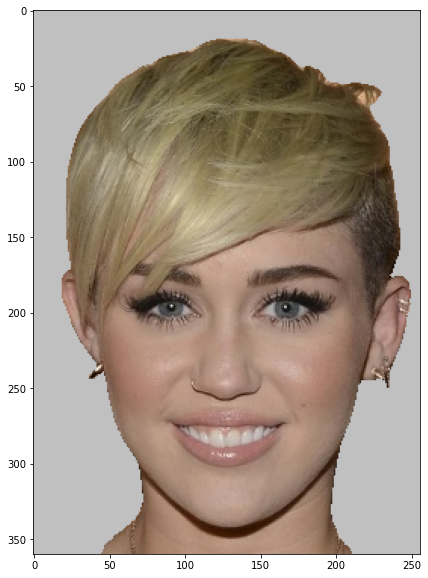

In [82]:
plt.figure(figsize=(10,10))
plt.imshow(result)

### Now print indiv fig if desired

In [83]:
im_path_out = os.path.join(imageOutPath, 'MileyC.jpg') 
im_path_out

'C:\\Users\\wadiav\\Documents\\PYTHON\\FaceFamiliarity\\BackgroundRemoval_SegAny\\P98CS\\ExtraFaces_Processed\\MileyC.jpg'

In [84]:
result = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)
cv2.imwrite(im_path_out, result)

True

### Use the mask to change the background and output the new image

## Automatic mask generation options

There are several tunable parameters in automatic mask generation that control how densely points are sampled and what the thresholds are for removing low quality or duplicate masks. Additionally, generation can be automatically run on crops of the image to get improved performance on smaller objects, and post-processing can remove stray pixels and holes. Here is an example configuration that samples more masks: